Duplicate rows: 0
Null values per column:
 Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany             

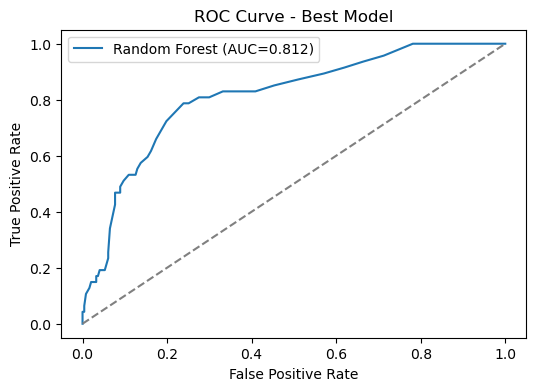

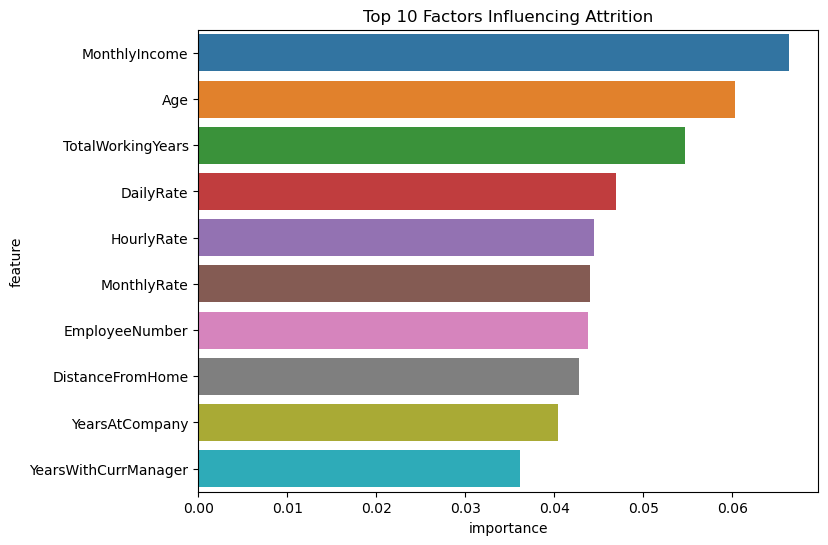


=== Retention Strategy Recommendations ===
- Focus on the factors with the highest importance, such as compensation, working hours, and work environment.
- Pay attention to employees with short tenure or high performance who are at risk of leaving.
- Implement career development and engagement programs for departments prone to high turnover.
- Evaluate flexible work policies or work-life balance initiatives to improve retention.


In [14]:
# =========================
# 1. Import library
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# =========================
# 2. Load dataset
# =========================
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

# =========================
# 3. Data check & cleaning
# =========================
print("Duplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()

print("Null values per column:\n", df.isnull().sum())

# =========================
# 4. Target variable
# =========================
df["Attrition"] = df["Attrition"].map({"Yes": 1, "No": 0})

# =========================
# 5. Split features & target
# =========================
X = df.drop("Attrition", axis=1)
y = df["Attrition"]

num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

# =========================
# 6. Preprocessor
# =========================
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

# =========================
# 7. Train-Test Split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =========================
# 8. Models
# =========================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    clf = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results[name] = {"auc": auc, "model": clf}

# =========================
# 9. Best model selection
# =========================
auc_scores = {name: info["auc"] for name, info in results.items()}
best_name = max(auc_scores, key=auc_scores.get)
best_model = results[best_name]["model"]

print(f"\nBest Model: {best_name} (AUC = {auc_scores[best_name]:.3f})")

# =========================
# 10. Save results & predictions for Looker Studio
# =========================
results_df = pd.DataFrame({
    "Model": list(auc_scores.keys()),
    "AUC": list(auc_scores.values())
})
results_df.to_csv("model_results.csv", index=False)

predictions_df = pd.DataFrame({
    "EmployeeID": X_test.index,
    "Attrition_Actual": y_test.values,
    "Attrition_Predicted": best_model.predict(X_test),
    "Prediction_Probability": best_model.predict_proba(X_test)[:, 1]
})
predictions_df.to_csv("predictions.csv", index=False)

print("\nCSV 'predictions.csv' saved — ready for Looker Studio.")

# =========================
# 11. ROC Curve
# =========================
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'{best_name} (AUC={auc_scores[best_name]:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Best Model")
plt.legend()
plt.show()

# =========================
# 12. Feature importance (if Random Forest)
# =========================
if best_name == "Random Forest":
    ohe_features = best_model.named_steps["preprocessor"]\
        .transformers_[1][1]\
        .named_steps["encoder"]\
        .get_feature_names_out(cat_features)
    all_features = np.concatenate([num_features, ohe_features])
    importances = best_model.named_steps["classifier"].feature_importances_
    feat_imp = pd.DataFrame({"feature": all_features, "importance": importances})
    feat_imp = feat_imp.sort_values(by="importance", ascending=False).head(10)

    plt.figure(figsize=(8, 6))
    sns.barplot(x="importance", y="feature", data=feat_imp)
    plt.title("Top 10 Factors Influencing Attrition")
    plt.show()

    print("\n=== Retention Strategy Recommendations ===")
    print("- Focus on the factors with the highest importance, such as compensation, working hours, and work environment.")
    print("- Pay attention to employees with short tenure or high performance who are at risk of leaving.")
    print("- Implement career development and engagement programs for departments prone to high turnover.")
    print("- Evaluate flexible work policies or work-life balance initiatives to improve retention.")
